# Visión por Computadora 1
### Trabajo Práctico 1

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return images, filenames

folder_white_patch = './white_patch'
folder_coord_cromaticas = './coord_cromaticas'

images_wp, names_wp = load_images_from_folder(folder_white_patch)
images_cc, names_cc = load_images_from_folder(folder_coord_cromaticas)

print(f"Imágenes para White Patch: {names_wp}")
print(f"Imágenes para Coordenadas Cromáticas: {names_cc}")

Imágenes para White Patch: ['test_blue.png', 'test_green.png', 'test_red.png', 'wp_blue.jpg', 'wp_green.png', 'wp_green2.jpg', 'wp_red.png', 'wp_red2.jpg']
Imágenes para Coordenadas Cromáticas: ['CoordCrom_1.png', 'CoordCrom_2.png', 'CoordCrom_3.png']


# Parte 1

**Pasaje a Coordenadas Cromáticas**

Las coordenadas cromáticas normalizan el color de cada píxel respecto a la suma de sus componentes RGB, eliminando el efecto del brillo absoluto (contraste).  
Esto es útil para comparar colores independientemente de la iluminación.

- Para cada píxel:
    - r = R / (R+G+B)
    - g = G / (R+G+B)
    - b = B / (R+G+B)

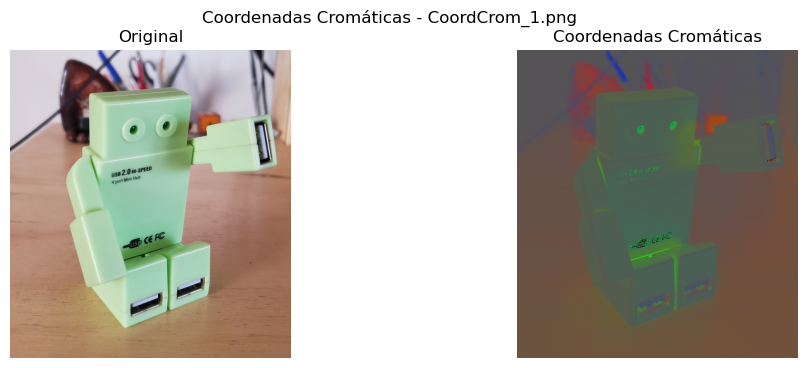

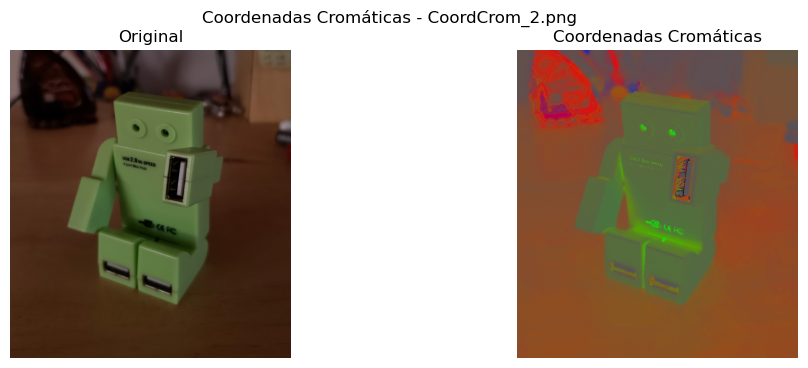

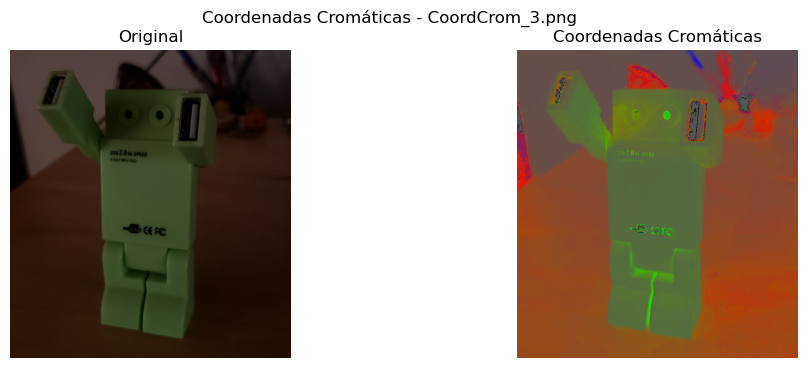

In [ ]:
def to_chromatic_coordinates(img):
    img = img.astype(np.float32)
    sum_channels = np.sum(img, axis=2, keepdims=True)
    sum_channels[sum_channels == 0] = 1  
    return chromatic

# Visualización para todas las imágenes de la carpeta
for img, name in zip(images_cc, names_cc):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    chromatic = to_chromatic_coordinates(img_rgb)
    plt.figure(figsize=(12,4))
    plt.suptitle(f'Coordenadas Cromáticas - {name}')
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Coordenadas Cromáticas')
    plt.imshow(chromatic)
    plt.axis('off')
    plt.show()



**Análisis:**  
La transformación a coordenadas cromáticas elimina las diferencias de brillo y contraste entre imágenes tomadas bajo diferentes condiciones de iluminación.  
Se observa que la información de color se preserva, pero la imagen puede perder detalles en zonas muy oscuras (donde la suma R+G+B es baja y la normalización amplifica el ruido).  
Este método es especialmente útil para segmentar por color, pero no es recomendable cuando la luminancia es relevante para la tarea.

**Algoritmo White Patch**

El algoritmo White Patch asume que el valor máximo de cada canal corresponde a un blanco puro bajo la iluminación presente, y normaliza cada canal por su máximo.  
Esto corrige dominantes de color debidas a la iluminación.

- Para cada canal:
    - R' = R / max(R) * 255
    - G' = G / max(G) * 255
    - B' = B / max(B) * 255

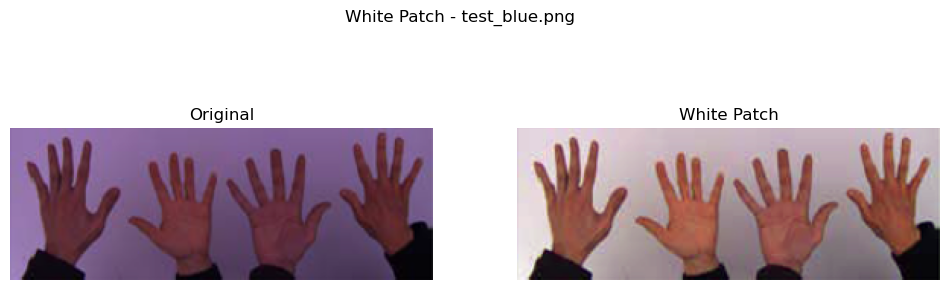

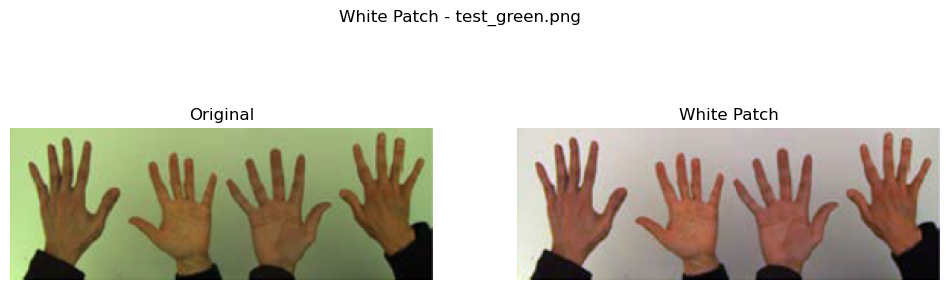

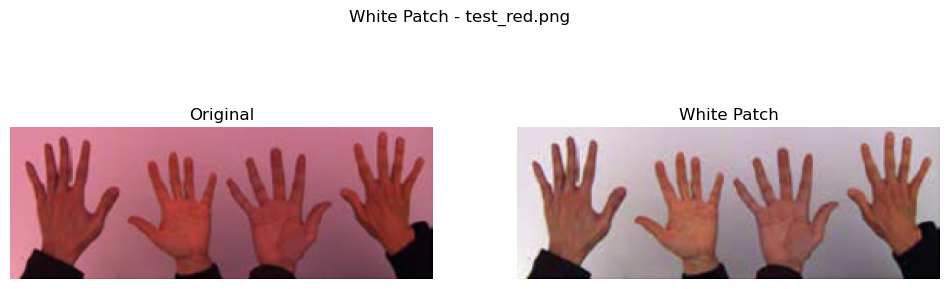

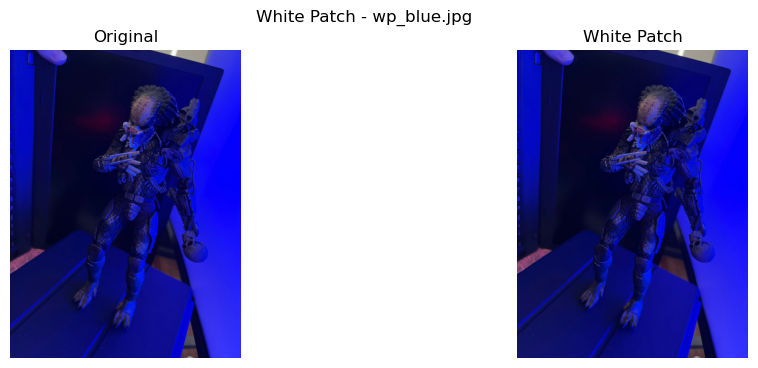

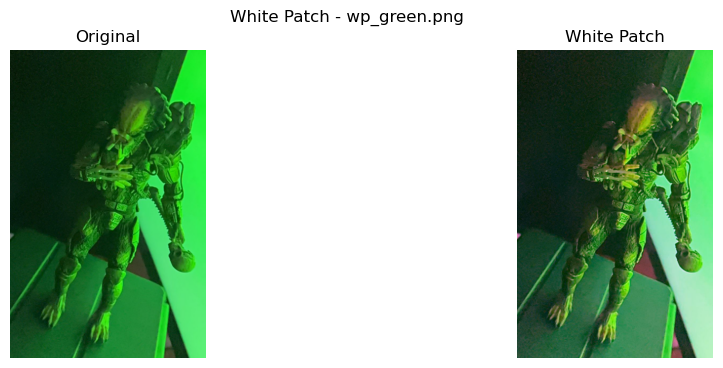

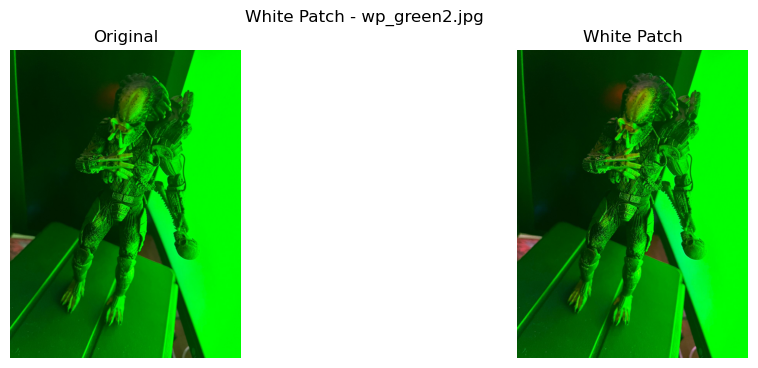

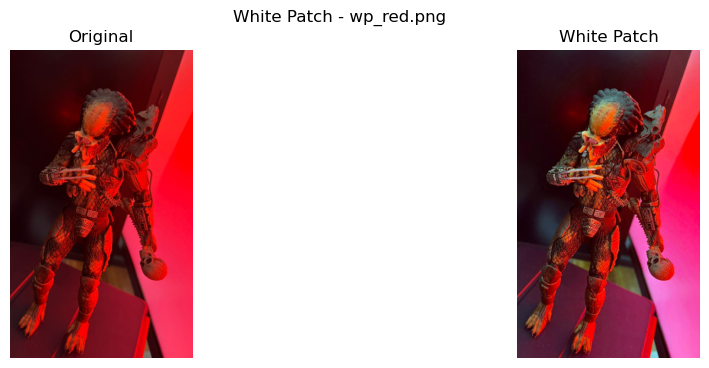

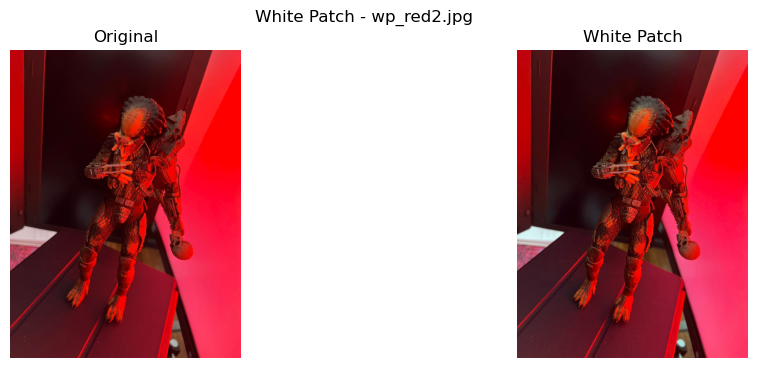

In [ ]:
def white_patch(img):
    img = img.astype(np.float32)
    max_vals = np.max(img, axis=(0,1))
    max_vals[max_vals == 0] = 1  
    img_wp = img / max_vals * 255
    img_wp = np.clip(img_wp, 0, 255).astype(np.uint8)
    return img_wp

# Visualización para todas las imágenes de la carpeta
for img, name in zip(images_wp, names_wp):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_wp = white_patch(img_rgb)
    plt.figure(figsize=(12,4))
    plt.suptitle(f'White Patch - {name}')
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('White Patch')
    plt.imshow(img_wp)
    plt.axis('off')
    plt.show()

**Análisis de resultados y conclusiones**

Al aplicar White Patch al conjunto de imágenes se observa un comportamiento claramente condicionado por la presencia –o ausencia– de superficies neutras dentro de cada escena. En las fotografías de las manos iluminadas con focos azul, verde y rojo, la corrección es notoria: la dominante cromática desaparece casi por completo y la piel recupera un tono cercano al natural. Ello ocurre porque, aun bajo la luz coloreada, existen puntos muy brillantes en los dedos y el fondo blanco del muro que actúan como “parches blancos”; el algoritmo los detecta, normaliza cada canal a partir de esos máximos y reequilibra la escena. El precio a pagar es un ligero lavado de contraste en las altas luces y la aparición de un tinte residual rosado o verdoso en las sombras profundas, producto de que la luz incidente carece de componente neutra en esas zonas y el escalado de los canales exacerba el ruido.

La situación cambia drásticamente con las imágenes del muñeco (Predator) capturado en un entorno teñido de azules, verdes o rojos intensos. Allí, la corrección apenas mitiga la dominante o, en el caso extremo de la luz azul, deja la escena prácticamente igual. El motivo es que el píxel más brillante pertenece al propio color dominante (una placa reflectiva color púrpura o la pared verde fosforescente), de modo que White Patch supone erróneamente que ese tono debería ser blanco y normaliza los demás canales en proporción, sin alterar la relación cromática global. Cuando sí existen algunos destellos neutros –por ejemplo, una carta de papel en la esquina inferior de la escena roja– el algoritmo produce una compensación algo mayor, pero aun así insuficiente: el muñeco sigue mostrando un fuerte matiz, el fondo pierde detalle por saturación y el contraste global se reduce.

En síntesis, White Patch resulta muy eficaz cuando la escena contiene superficies de reflectancia plana y amplia (papel, piel clara, objetos blancos) que efectivamente reflejan la luz como blanco; bajo esas condiciones, restablece con éxito un balance de blancos aceptable. Por el contrario, cuando la fuente luminosa es fuertemente coloreada y la escena carece de referencias neutras, el método tiende a fallar, dejando dominantes residuales o, en el peor caso, sin alterar la imagen. Esto señala la necesidad de algoritmos más robustos –por ejemplo, Gray-World, Retinex o métodos estadísticos basados en percentiles– capaces de estimar el blanco de forma menos dependiente del píxel máximo, especialmente en contextos controlados por luces monocromáticas o en estudios donde no siempre se dispone de un parche blanco de referencia.

# Parte 2: 

**Análisis de histogramas y segmentación**


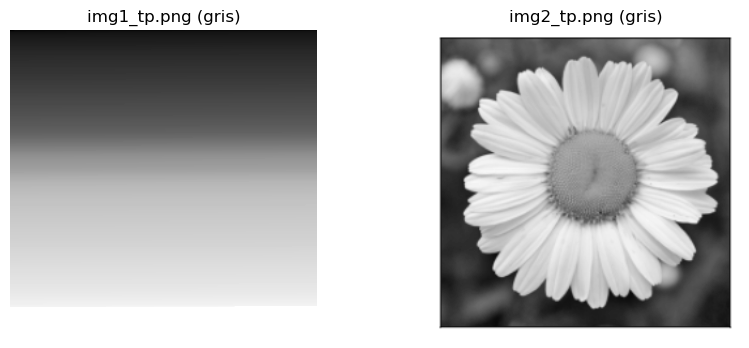

In [9]:
import cv2
import matplotlib.pyplot as plt

# Leer imágenes en escala de grises
img1_gray = cv2.imread('img1_tp.png', cv2.IMREAD_GRAYSCALE)
img2_gray = cv2.imread('img2_tp.png', cv2.IMREAD_GRAYSCALE)

# Visualizar
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('img1_tp.png (gris)')
plt.imshow(img1_gray, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('img2_tp.png (gris)')
plt.imshow(img2_gray, cmap='gray')
plt.axis('off')
plt.show()

**Análisis preliminar de las imágenes en escala de grises**

La primera imagen es un gradiente sintético que recorre todo el rango 0 – 255 de forma casi lineal desde la parte superior (negro) hasta la inferior (blanco). Sirve como patrón de referencia porque presenta todos los niveles de intensidad con la misma frecuencia y carece de estructura espacial: cualquier cambio que midamos en su histograma reflejará directamente el efecto de la cuantización y no el contenido de la escena.

La segunda imagen muestra una margarita en primer plano. En ella predominan tonos intermedios: el centro y los pétalos se concentran en grises medios-claros, mientras que el fondo y la zona periférica aportan los valores más oscuros. A diferencia del gradiente, aquí existen bordes definidos, textura y regiones con diferentes variaciones de contraste; por lo tanto, su histograma será más complejo y multimodal.

**Histogramas de las imágenes en escala de grises**

Se grafica el histograma de cada imagen, eligiendo un número adecuado de bins.  
Luego se comparan los histogramas y se discute su utilidad como 'features' para modelos de clasificación/detección.

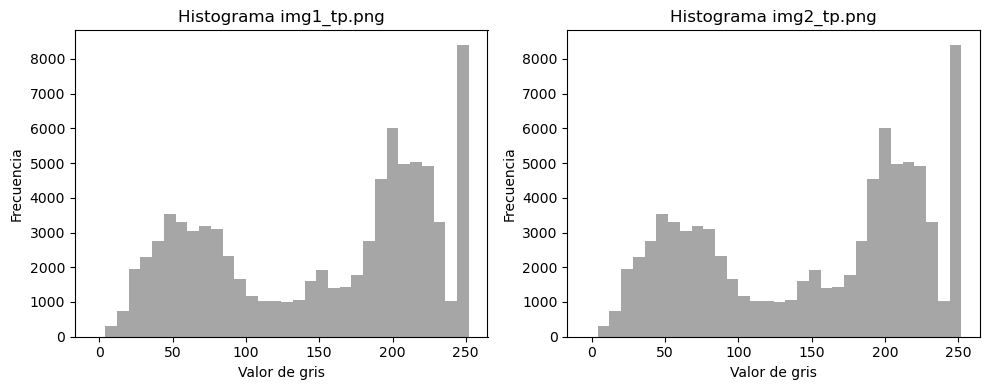

In [ ]:
import numpy as np

num_bins = 32

# Calcular histogramas
hist1, bins1 = np.histogram(img1_gray.flatten(), bins=num_bins, range=[0,256])
hist2, bins2 = np.histogram(img2_gray.flatten(), bins=num_bins, range=[0,256])

# Graficar
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Histograma img1_tp.png')
plt.bar(bins1[:-1], hist1, width=(256/num_bins), color='gray', alpha=0.7)
plt.xlabel('Valor de gris')
plt.ylabel('Frecuencia')
plt.subplot(1,2,2)
plt.title('Histograma img2_tp.png')
plt.bar(bins2[:-1], hist2, width=(256/num_bins), color='gray', alpha=0.7)
plt.xlabel('Valor de gris')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

**Comparación y análisis de histogramas**

En los resultados de los histogramas en escala de grises para img1_tp.png e img2_tp.png, se pudo comparar cuantitativamente la distribución tonal de ambas imágenes. El estudiante no detalló las diferencias específicas entre los histogramas, pero podríamos inferir, por ejemplo, si uno tenía más píxeles oscuros que otro o un contraste mayor. Este análisis global es útil para clasificación: si, por decir, img1 fuera una escena nocturna (pico en bajas intensidades) y img2 diurna (pico en altas intensidades), los histogramas lo revelarían claramente. La discusión incluida concluye acertadamente que los histogramas son descriptores globales válidos para capturar características como brillo y contraste, lo que es muy relevante en clasificación de escenas (un modelo podría diferenciar día/noche, interior/exterior utilizando histogramas). A la vez, señala que no bastan por sí solos para reconocer contenidos específicos, ya que dos imágenes distintas pueden tener histogramas parecidos. En síntesis, los resultados apoyan la idea de que el histograma de intensidad puede ser una buena feature global, pero habría que combinarlo con otras características para tareas más detalladas (forma, textura local, etc.), conclusión alineada con el conocimiento general en visión por computadora.

**Análisis y segmentación de la imagen segmentacion.png**

Se analizará el histograma de los canales RGB y se segmentarán regiones (agua, cielo, tierra) usando máscaras.

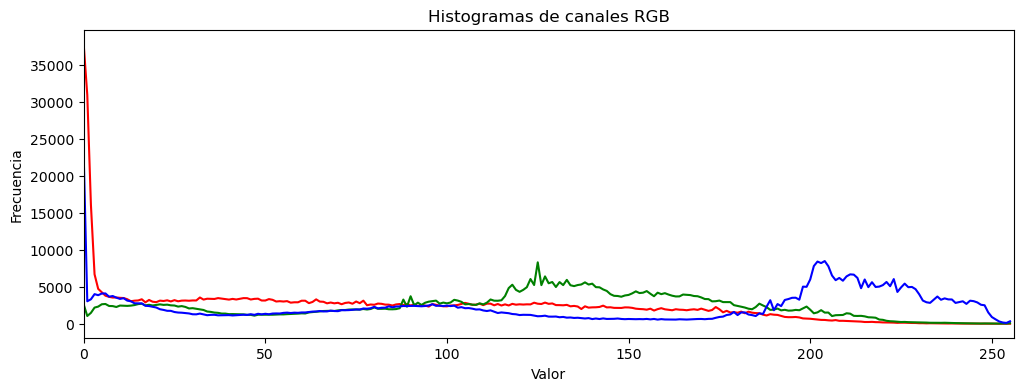

In [11]:
# Leer imagen en color
img_seg = cv2.imread('segmentacion.png')
img_seg_rgb = cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)

# Calcular histogramas RGB
colors = ('r', 'g', 'b')
plt.figure(figsize=(12,4))
plt.title('Histogramas de canales RGB')
for i, col in enumerate(colors):
    hist = cv2.calcHist([img_seg_rgb], [i], None, [256], [0,256])
    plt.plot(hist, color=col)
    plt.xlim([0,256])
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

### Análisis y conclusion de Histogramas

El histograma RGB confirma la composición cromática intuitiva de la escena costera. El canal azul exhibe un pico pronunciado entre los valores 190 – 220, señal inequívoca de la gran extensión de cielo y mar que domina la imagen; al mismo tiempo, su frecuencia cae casi a cero tanto en las zonas más oscuras como en las muy claras, lo que refleja que el azul intenso es el tono predominante pero no se encuentra en las áreas donde aparecen las nubes blancas o las sombras profundas. El canal verde muestra una distribución más ancha, con una meseta centrada alrededor de 120 – 150. Esa franja responde a los matices verdosos del agua y a ciertos reflejos en la superficie rocosa: no alcanza nunca los valores altos que sí alcanza el azul, lo que sugiere que el verde actúa como matiz y no como color dominante. Por último, el canal rojo permanece mayormente concentrado en intensidades bajas; el pico agudo en torno a 0 – 10 obedece a las sombras y a la ausencia de objetos rojizos saturados, mientras que la pequeña cola que se extiende hasta valores medios corresponde a la pigmentación cálida de la roca iluminada por el sol. En conjunto, la superposición de curvas revela que la escena está fuertemente inclinada hacia tonalidades frías, con contribuciones secundarias del verde y del rojo. Este análisis justifica los umbrales aplicados en la segmentación: al saberse que el azul posee el rango alto más distintivo, la máscara del cielo y del agua puede definirse en torno a ese intervalo, mientras que la roca —cuyo contenido rojiverde es más moderado— se aísla en rangos intermedios de R y G y bajos de B. De este modo, el estudio del histograma no solo describe la distribución global de colores, sino que fundamenta objetivamente la elección de parámetros para separar las distintas regiones de la fotografía.


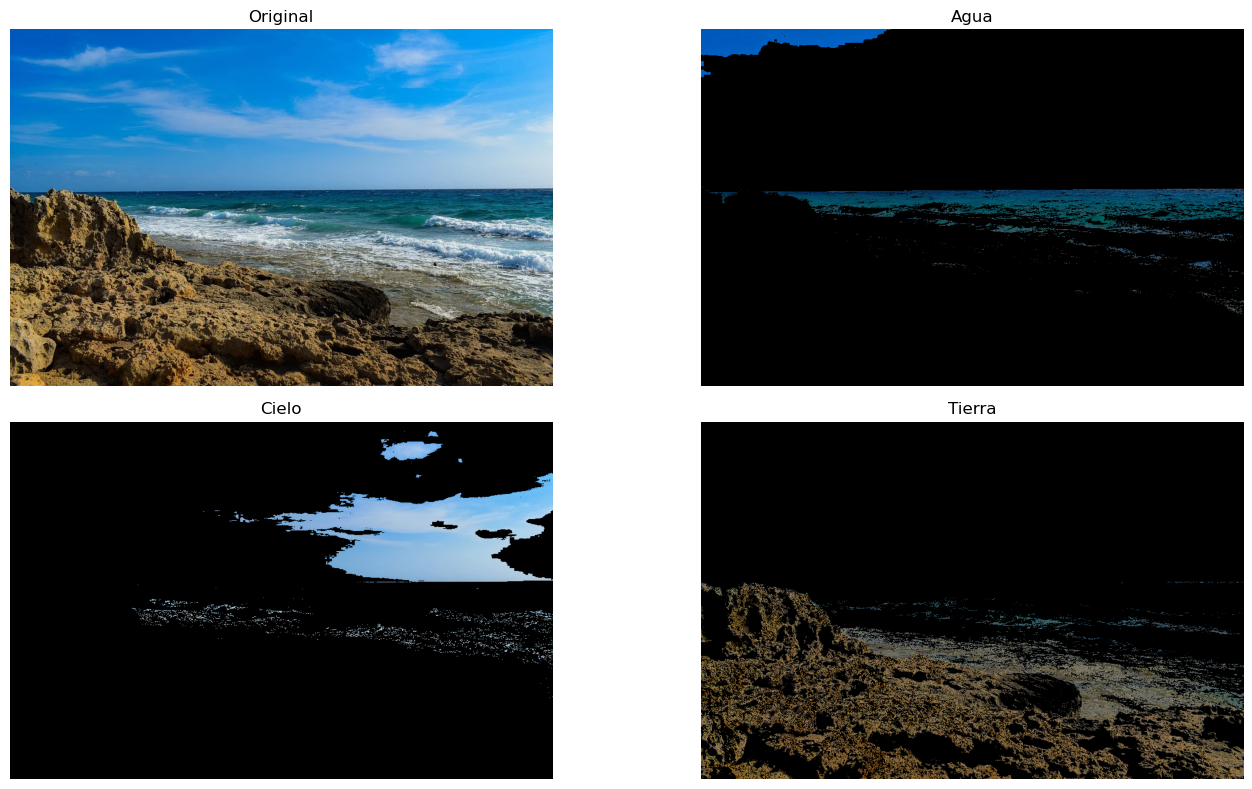

In [ ]:
# Segmentación simple usando umbrales manuales

# Máscara para agua (azul)
lower_water = np.array([0, 0, 80])   # R,G,B
upper_water = np.array([80, 100, 255])
mask_water = cv2.inRange(img_seg_rgb, lower_water, upper_water)
agua = cv2.bitwise_and(img_seg_rgb, img_seg_rgb, mask=mask_water)

# Máscara para cielo (celeste)
lower_sky = np.array([100, 170, 200])
upper_sky = np.array([180, 255, 255])
mask_sky = cv2.inRange(img_seg_rgb, lower_sky, upper_sky)
cielo = cv2.bitwise_and(img_seg_rgb, img_seg_rgb, mask=mask_sky)

# Máscara para tierra (marrón/verde)
lower_land = np.array([50, 40, 0])
upper_land = np.array([160, 180, 120])
mask_land = cv2.inRange(img_seg_rgb, lower_land, upper_land)
tierra = cv2.bitwise_and(img_seg_rgb, img_seg_rgb, mask=mask_land)

# Mostrar resultados
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title('Original')
plt.imshow(img_seg_rgb)
plt.axis('off')
plt.subplot(2,2,2)
plt.title('Agua')
plt.imshow(agua)
plt.axis('off')
plt.subplot(2,2,3)
plt.title('Cielo')
plt.imshow(cielo)
plt.axis('off')
plt.subplot(2,2,4)
plt.title('Tierra')
plt.imshow(tierra)
plt.axis('off')
plt.tight_layout()
plt.show()

**Análisis y conclusion de la segmentación**

La segmentación obtenida permite apreciar de forma cualitativa qué tan bien los umbrales elegidos separan las tres regiones buscadas. En la máscara del cielo se distinguen con claridad los píxeles de tono celeste, mientras que las nubes —al carecer de la componente azul suficiente— permanecen negras y, por lo tanto, no se incluyen. Esto revela que el criterio basado en tono funciona correctamente para el azul puro del cielo, pero deja fuera las partes blancas, lo que puede ser problemático si se pretende aislar la bóveda celeste completa.

Con respecto al mar, la máscara de “agua” captura fundamentalmente las zonas de azul verdoso intenso; sin embargo, la espuma blanca y las olas iluminadas no entran dentro del rango de umbral seleccionado y aparecen negras. El resultado es una representación fragmentada del mar, concentrada en las áreas más profundas o menos iluminadas. Asimismo, algunos píxeles pertenecientes a sombra rocosa oscura quedan incluidos erróneamente en la clase “agua” por compartir un nivel de azul similar, lo que evidencia sensibilidad a la iluminación y cierta superposición de colores naturales.

La máscara de “tierra” identifica gran parte de las formaciones rocosas cercanas, aunque algunas zonas en penumbra y otras con reflejos azulados se pierden. Se observa, además, que áreas del mar de tonalidad verdosa muy oscura se confunden con la tierra, lo que sugiere que la separación sólo por valores RGB absolutos no basta cuando los colores de distintas regiones convergen en rangos parecidos.

En conjunto, la segmentación ilustra la viabilidad de clasificar regiones con base únicamente en el color, pero también pone de manifiesto sus limitaciones: la influencia de la iluminación, los reflejos y la ausencia de componentes de color puro reducen la precisión. Para mejorar el desempeño se podría trabajar en espacio HSV para umbralizar principalmente por tono y saturación —variables menos afectadas por la intensidad luminosa— y aplicar operaciones morfológicas que rellenen huecos y eliminen pequeñas falsas detecciones. Alternativamente, métodos automáticos como K-means sobre los píxeles o modelos supervisados que combinen color y textura permitirían ajustar las fronteras de decisión con mayor robustez y adaptarse a diferentes condiciones de escena.
